In [9]:
import numpy as np
import seaborn as sns
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
# import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#Mathieu's aestetics
import sys
# see https://github.com/mathren90/plotFunc
sys.path.append('/home/math/Documents/Research/codes/plotFunc/')
from plotDefaults import *
import matplotlib.pyplot as plt


G = 6.67e-11
c = 2.998e8
Msun = 2e30
Rsun = 7e8
year = 3600.*24.*365
kpc = 1e3*3.086e16

In [10]:
set_plotDefaults()

done in plotDefaults.py


# Helper Functions

At lowest PN order, a compact binary's frequency evolves as (Maggiore Eq. 4.18)
\begin{equation}
{\dot f}_{\rm gw} = \frac{96}{5} \pi^{8/3} \left(\frac{G \mathcal{M}}{c^3}\right)^{5/3} f_{\rm gw}^{11/3}
\end{equation}

We will need an expression for the strain amplitude of a quasi-circular face-on compact binary. Consider a toy binary with chirp mass $\mathcal{M}$ at distance $D$. Neglecting evolution, the plus- and cross-polarizations will each have amplitude (Maggiore Eq. 4.3):
\begin{equation}
\begin{aligned}
A(t) &= \frac{4}{D} \left(\frac{G \mathcal{M}_c}{c^2} \right)^{5/3} \left(\frac{2\pi f_\mathrm{orb}}{c}\right)^{2/3} \\
&= \frac{4}{D} \left(\frac{G \mathcal{M}_c}{c^2} \right)^{5/3} \left(\frac{\pi f_\mathrm{gw}}{c}\right)^{2/3}
\end{aligned}
\end{equation}

In [11]:
def compute_Mc(m1,m2):
    
    """
    Returns chirp mass, given binary component masses
    """
    
    Mtot = m1+m2
    eta = (m1*m2)/np.power(m1+m2,2.)
    return np.power(eta,3./5.)*Mtot

def fdotGW_from_fGW_Mc(f_gw,Mc):
    
    """
    Returns df/dt assuming *purely gravitational-wave-driven evolution*, given a present GW frequency
    (i.e. twice the present orbital frequency) and a binary chirp mass.
    See Eq. 4.18 of Maggiore
    """
    
    return (96./5.)*np.power(np.pi,8./3.)*np.power(G*Mc*Msun/c**3.,5./3.)*np.power(f_gw,11./3.)

def amp_from_fGW_mass_dist(f_gw,Mc,D):
    
    """
    Gravitational wave amplitude given a present GW frequency, binary chirp mass, and source distance.
    See Eq. 4.3 of Maggiore
    """
    
    return (4./(D*kpc))*np.power(G*Mc*Msun/c**2.,5./3.)*np.power(np.pi*f_gw/c,2./3.)

def a_from_fGW_mass(f_gw,m1,m2):
    
    """
    Binary separation, given current GW frequency and component masses.
    This is just Kepler's Law...
    """
    
    return np.power(G*(m1+m2)*Msun/(np.pi*f_gw)**2,1./3.)

def fGW_from_a_mass(a,m1,m2):
    
    """
    Binary separation, given current GW frequency and component masses.
    This is just Kepler's Law...
    """
    
    return np.power(G*(m1+m2)*Msun/(np.pi**2*a**3),1./2.)

Let's define the LISA PSD. I'll follow Eq. 1 of [Robson et al](https://arxiv.org/pdf/1803.01944.pdf)

/home/math/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/math/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'PSD')

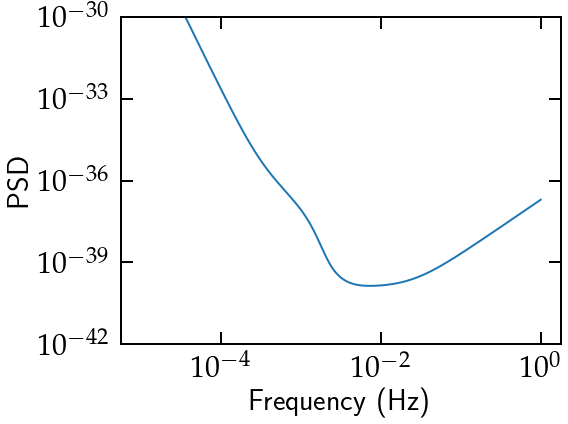

In [12]:
# https://arxiv.org/pdf/1803.01944.pdf

L_arm = 2.5e9
fref = 19.09e-3
def LISA_sensitivity(f):
    
    # Instrumental noise
    P_oms = np.power(1.5e-11,2.)*(1.+np.power(2.e-3/f,4.))
    P_acc = np.power(3.e-15,2.)*(1.+np.power(0.4e-3/f,2.))*(1.+np.power(f/8e-3,4))
    S_n = (10./(3.*L_arm*L_arm))*(P_oms + 4.*P_acc/np.power(2.*np.pi*f,4.))*(1.+(3./5.)*np.power(f/fref,2.))
    
    # Confusion noise (assume four years)
    A = 9e-45
    alpha = 0.138
    beta = -221.
    k = 521.
    gamma = 1680.
    fk = 1.13e-3
    S_conf = A*np.power(f,-7./3.)*np.exp(-f**alpha+beta*f*np.sin(k*f))*(1.+np.tanh(gamma*(fk-f)))
    
    # Impose upper frequency limit
    S_n[f>=1.] = np.inf
    S_conf[f>=1.] = np.inf
    
    return S_n + S_conf

f = np.logspace(-5,2,1000)
strain_sensitivity = LISA_sensitivity(f)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(f,strain_sensitivity,lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-42,1e-30)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')

### LISA Signal-To-Noise

Averaging over sky position and binary inclination angles, the mean squared-SNR of a binary signal is

\begin{equation}
\langle \mathrm{SNR}\rangle^2 = \frac{16}{5} \int_0^\infty \frac{\mathcal{R} A^2(f)}{P_n(f)} df,
\end{equation}

where $A(f)$ is the strain amplitude of a face-on binary, $P_n(f)$ is the noise power spectral density in the detector, and $\mathcal{R}$ is the sky-averaged response function of the LISA detector.
In the low-frequency limit (and after adding LISA's multiple channels), $\mathcal{R} \approx \frac{3}{10}$; see Robson's Eq. 8.
Rearranging slightly,
\begin{equation}
\begin{aligned}
\langle \mathrm{SNR}\rangle^2 &= \frac{16}{5} \int_0^\infty \frac{A^2(f)}{P_n(f)/\mathcal{R}} df, \\
    &= \frac{16}{5} \int_0^\infty \frac{A^2(f)}{S_n(f)} df,
\end{aligned}
\end{equation}
where $S_n(f)$ is the LISA equivalent strain sensitivity (i.e. the *physical* strain power of incident GWs that is equivalent to the noise power in the instrument).

In [13]:
def snr_from_f_fdot(f0,fdot0,m1=1.,m2=1.,D=3.):
    
    # We'll truncate any frequency evolution at f = 3e-2 Hz,
    # above which we expect tidal disruption of binaries.
    # If we're *already* above this limit, then return vanishing SNR
    if f0>=3e-2:
        return 0.
    
    # Otherwise create a grid between f0 and the final observed frequency:
    # the disruption frequency or f(t=0) + (df/dt)*(5 years), whichever is lowest
    f_final = min(3e-2,f0+fdot0*5.*year)
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/1000.)
    
    # Calculate the corresponding GW amplitudes and orbital separations as
    # a function of these (GW) frequencies
    amp_at_f = amp_from_fGW_mass_dist(fourier_freqs,compute_Mc(m1,m2),D)
    sep_at_f = a_from_fGW_mass(fourier_freqs,m1,m2)

    # Get the Fourier amplitude at each frequency, as given by the SPA
    # (e.g. Eq. 3.14 of 10.1103/PhysRevD.80.084043).
    # Note that, for lack of a better option, we are assuming constant fdot
    fdot_at_f = fdot0
    hf = amp_at_f/np.sqrt(fdot_at_f)
    
    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)

    return np.sqrt(rho2)

In [14]:
# Load file with gas drag data
f_ref, fdot_drag = np.loadtxt('fdot_and_f_m1_0.5_m2_0.3.txt',unpack=True,usecols=(0,2))

# Verification binary data from Kupfer+ 2018
# GW frequencies are taken from Table 2
# Masses are from Table 1 (when an uncertain range is provided, take the average)
wd_fs = np.array([6.22,3.51,3.22,2.12,1.94,1.84,1.81,1.48,1.45,1.36,1.25,2.61,1.68,0.84,0.51,0.47])*1e-3
wd_m1s,wd_m2s = np.transpose(np.array([\
                                 [0.55,0.27],\
                                 [0.8,0.177],\
                                 [0.8,0.161],\
                                 [0.8,0.1],\
                                 [0.68,0.125],\
                                 [0.8,0.085],\
                                 [(0.8+0.49)/2., (0.088+0.048)/2.],\
                                 [0.8,0.066],\
                                 [0.8,0.064],\
                                 [(1.1+0.67)/2., (0.088+0.044)/2.],\
                                 [(1.17+0.78)/2., (0.109+0.059)/2.],\
                                 [0.247,0.49],\
                                 [0.312,0.75],\
                                 [0.298,0.76],\
                                 [0.275,0.76],\
                                 [0.54,0.79]
                                ])
                          )

wd_etas = wd_m1s*wd_m2s/(wd_m1s+wd_m2s)**2.
wd_Mcs = np.power(wd_etas,3./5.)*(wd_m1s+wd_m2s)

No handles with labels found to put in legend.


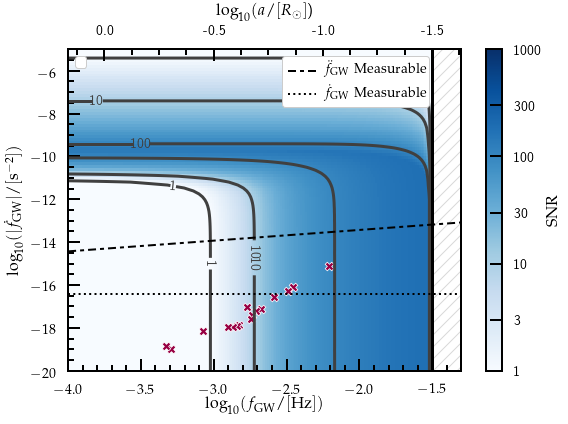

In [15]:
# Loop across initial observed GW frequencies and frequency derivatives
# Calculate sky-averaged SNR for each, assuming a 0.5+0.3 system at 3 kpc
f_gws = np.logspace(-4.,-1.5,200)
fdot_gws = np.logspace(-20,6,190)
rhos = np.zeros((f_gws.size,fdot_gws.size))
for i in range(f_gws.size):
    for j in range(fdot_gws.size):
        rhos[i,j] = snr_from_f_fdot(f_gws[i],fdot_gws[j],10,10, D=3000)

# Create colormap and label a few contours
fig,ax = plt.subplots(figsize=(8,6))

PS = ax.pcolormesh(np.log10(f_gws),np.log10(fdot_gws),np.log10(rhos).T,cmap='Blues',vmin=0,vmax=3,rasterized=True)
CS = ax.contour(np.log10(f_gws),np.log10(fdot_gws),rhos.T,levels=[1,10,100,300],colors='#404040')

# Plot phase space locations of verification binaries
ax.scatter(np.log10(wd_fs),np.log10(fdotGW_from_fGW_Mc(wd_fs,wd_Mcs)),marker='X',color='#980043',zorder=1,edgecolors='white',linewidths=0.75,s=75)

# Plot bounds from pure gas and pure GW-driven evolution
xs = 10.**np.linspace(-4,0,100)
ys = fdotGW_from_fGW_Mc(xs,compute_Mc(0.5,0.3))
# ax.plot(np.log10(f_ref),np.log10(fdot_drag),lw=2.5,color='orange',label=r'$\mathrm{Gas\ Drag\ (No\ Feedback)}$')
# ax.plot(np.log10(xs),np.log10(ys),lw=2.5,color='orange',ls='--',label=r'$\mathrm{GW\ Emission}$')

# Misc plot formatting
ax.clabel(CS, inline=1, fontsize=14, fmt="%.0f", inline_spacing=0, 
          manual=[(-3.3,-15),(-2.9,-15), (-2.6,-15), (-2.45,-14.5),(-3.8,-8),(-3.5,-9)])
ax.set_xlabel(r'$\log_{10}(f_\mathrm{GW} / \mathrm{[Hz]})$',fontsize=16)
ax.set_ylabel(r'$\log_{10}(|\dot f_\mathrm{GW}| / [\mathrm{s}^{-2}])$',fontsize=16)
ax.tick_params(labelsize=14)
ax.yaxis.tick_left()

# Set up colorbar and overwrite log10(SNRs) with standard SNRs
cb = fig.colorbar(PS)
cb.set_label(label="$\mathrm{SNR}$",fontsize=16,labelpad=6)
cb.ax.tick_params(labelsize=14) 
cb.set_ticks(np.log10([1,3,10,30,100,300,1000]))
cb.ax.tick_params(which = 'minor', length = 0)
cb.set_ticklabels([1,3,10,30,100,300,1000])
ax.set_ylim(-20,-5)
ax.set_xlim(-4,-1.3)

# Plot lines denoting min detectable fdots and fddots
fdot_min = 1./(5.*year)**2.
fddot_min = (2./(5.*year))/(5.*year)**2.
fdot_at_minimum_fddot = np.sqrt((3./11.)*xs*fddot_min)
ls1, = ax.plot(np.log10(xs),np.log10(fdot_at_minimum_fddot),color='black',dashes=(4,2,2,2),lw=2)
ls2 = ax.axhline(y=np.log10(fdot_min),color='black',ls=':',lw=2)

# Construct secondary x-axis and get proper tick labels/positions
semi_as = a_from_fGW_mass(f_gws,0.5,0.3)/Rsun
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.tick_params(labelsize=14)
logR_ticks = np.linspace(0,-1.5,4)
logfGW_vals_at_R_ticks = np.log10(fGW_from_a_mass(10.**logR_ticks*Rsun,0.5,0.3))
ax2.set_xticks(logfGW_vals_at_R_ticks)
ax2.set_xticklabels(logR_ticks)
ax2.set_xlabel(r'$\log_{10}(a / [R_\odot]$)',fontsize=16)

# Legends
leg = ax.legend([ls1,ls2], ["$\ddot f_\mathrm{GW}\ \mathrm{Measurable}$", "$\dot f_\mathrm{GW}\  \mathrm{Measurable}$"], fontsize=14,
                  frameon=True,framealpha=1,loc=(0.545,0.82), handletextpad=0.5)
fig.add_artist(leg)
ax.legend(loc='upper left',fontsize=14,frameon=True,framealpha=1,labelspacing=0.8, handletextpad=0.5)

# Fill in the region to the right of logf = -1.5
ax.axvline(x=-1.5,color='black')
ax.fill_betweenx([-20,-5],-1.5,-1.3,hatch='//',facecolor='white',edgecolor='grey',alpha=0.3)

plt.tight_layout()
# plt.savefig('snr_grid_no_detectability.pdf',bbox_inches='tight')